## Analisi delle epoche 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Leggere il file CSV
file_path = 'Metriche/Metriche_ResNet18/saved_models_Multiclass/training_metrics.csv'
df = pd.read_csv(file_path)

# Filtrare i dati per fase di training e validazione
train_data = df[df['Phase'] == 'train']
val_data = df[df['Phase'] == 'val']

# Creare il grafico per train_loss e val_loss
plt.figure(figsize=(12, 6))
plt.plot(train_data['Epoch'], train_data['Loss'], color='black', label='Train Loss')
plt.plot(val_data['Epoch'], val_data['Loss'], color='red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Creare il grafico per f1_score di training e validation
plt.figure(figsize=(12, 6))
plt.plot(train_data['Epoch'], train_data['F1'], color='black', label='Train F1 Score')
plt.plot(val_data['Epoch'], val_data['F1'], color='red', label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Creare il grafico per precision di training e validation
plt.figure(figsize=(12, 6))
plt.plot(train_data['Epoch'], train_data['Precision'], color='black', label='Train Precision')
plt.plot(val_data['Epoch'], val_data['Precision'], color='red', label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.grid(True)
plt.show()

# Creare il grafico per recall di training e validation
plt.figure(figsize=(12, 6))

plt.plot(train_data['Epoch'], train_data['Recall'], color='black', label='Train Recall')
plt.plot(val_data['Epoch'], val_data['Recall'], color='red', label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.grid(True)
plt.show()

## Testing AlexNet Binario

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetBinario'
weights_path = 'Metriche/Metriche_AlexNet/AlexNet_saved_models_Binary/AlexNet_finetuned.pth'
metrics_path = 'Metriche/Metriche_AlexNet/AlexNet_saved_models_Binary/training_metrics.csv'
results_path = 'testing/AlexNet_Binary_best.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilità della classe positiva
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(results, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall', 'Threshold', 'Threshold Precision', 'Threshold Recall', 'Threshold F1'])
        writer.writerow(results)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.alexnet()
num_ftrs = model.classifier[6].in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

model.classifier[6] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    model.load_state_dict(torch.load(absolute_weights_path, map_location=torch.device('cpu')), strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test
test_dataset = load_dataset('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Calcola la curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probs)

# Visualizzazione della curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Imposta una soglia specifica
threshold = 0.5
specific_preds = (all_probs >= threshold).astype(int)
specific_precision = precision_score(all_labels, specific_preds, average='weighted', zero_division=1)
specific_recall = recall_score(all_labels, specific_preds, average='weighted', zero_division=1)
specific_f1 = f1_score(all_labels, specific_preds, average='weighted', zero_division=1)

print(f'Specific Threshold: {threshold}')
print(f'Precision: {specific_precision:.4f}, Recall: {specific_recall:.4f}, F1: {specific_f1:.4f}')

# Salva i risultati del test inclusa la soglia e le metriche relative
test_results = [test_loss, test_acc, test_f1, test_precision, test_recall, threshold, specific_precision, specific_recall, specific_f1]
save_test_results(test_results, results_path)

## AlexNet Multiclasse

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetMulticlass'  
weights_path = 'Metriche_NoAug/AlexNet_Metriche_NoAug/AlexNet_saved_models_MultiClass_NoAug_10Patience/AlexNet_finetuned.pth'
metrics_path = 'Metriche_NoAug/AlexNet_Metriche_NoAug/AlexNet_saved_models_MultiClass_NoAug_10Patience/training_metrics.csv'
results_path = 'testing/AlexNet_Multiclasse_best_NoAug.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Probabilità per ogni classe
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(results, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall'])
        writer.writerow(results)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.alexnet()
num_ftrs = model.classifier[6].in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

# Modifica il livello finale del modello
model.classifier[6] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello tranne l'ultimo livello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    state_dict = torch.load(absolute_weights_path, map_location=torch.device('cpu'))
    state_dict['classifier.6.weight'] = model.classifier[6].weight
    state_dict['classifier.6.bias'] = model.classifier[6].bias
    model.load_state_dict(state_dict, strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test con gestione delle eccezioni
def load_dataset_with_error_handling(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")

    dataset = datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

    valid_samples = []
    for path, target in dataset.samples:
        try:
            dataset.loader(path)  # Try to load the image to ensure it's valid
            valid_samples.append((path, target))
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: {path}")

    dataset.samples = valid_samples
    return dataset

test_dataset = load_dataset_with_error_handling('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Calcola la curva Precision-Recall per ogni classe
for i in range(num_classes):
    precisions, recalls, thresholds = precision_recall_curve([1 if label == i else 0 for label in all_labels], all_probs[:, i])
    
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label=f'Precision-Recall Curve (Class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class {i})')
    plt.legend()
    plt.show()

# Non possiamo impostare una soglia specifica per un problema multiclasse come facciamo per un problema binario,
# ma possiamo calcolare le metriche complessive e salvare i risultati.
test_results = [test_loss, test_acc, test_f1, test_precision, test_recall]
save_test_results(test_results, results_path)


## Testing ResNet Binario 

Directory exists: DatasetBinario
Directory exists: DatasetBinario\test
Number of classes: 2
Caricamento dei pesi salvati da C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\Metriche_NoAug\ResNet18_Metriche_NoAug\ResNet_saved_models_Binary_NoAug_10Patience\epoch_12_model.pth
Test Loss: 0.0374 Acc: 0.9928 F1: 0.9928 Precision: 0.9928 Recall: 0.9928


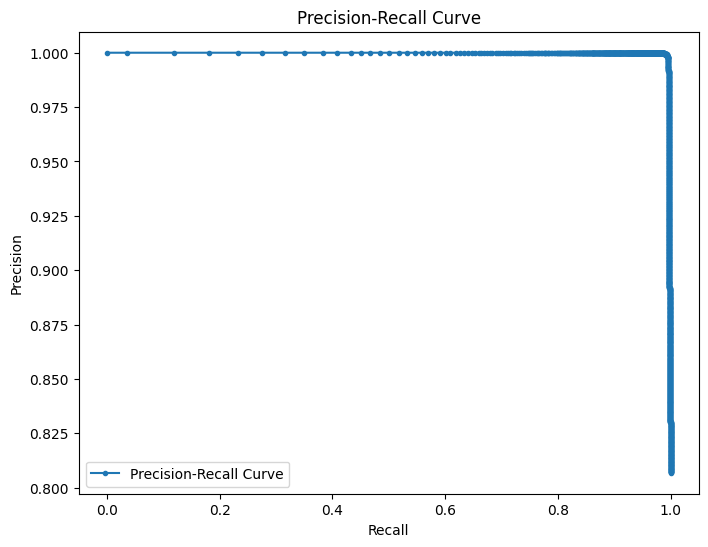

Specific Threshold: 0.5
Precision: 0.9928, Recall: 0.9928, F1: 0.9928


In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetBinario'  
weights_path = 'Metriche_NoAug/ResNet18_Metriche_NoAug/ResNet_saved_models_Binary_NoAug_10Patience/epoch_12_model.pth'
metrics_path = 'Metriche_NoAug/ResNet18_Metriche_NoAug/ResNet_saved_models_Binary_NoAug_10Patience/training_metrics.csv'
results_path = 'testing/ResNet_Binary_12_NoAug.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilità della classe positiva
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(results, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall', 'Threshold', 'Threshold Precision', 'Threshold Recall', 'Threshold F1'])
        writer.writerow(results)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18()
num_ftrs = model.fc.in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    model.load_state_dict(torch.load(absolute_weights_path, map_location=torch.device('cpu')), strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test
test_dataset = load_dataset('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Calcola la curva Precision-Recall
# Calcola la curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probs)

# Visualizzazione della curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Imposta una soglia specifica
threshold = 0.5
specific_preds = (all_probs >= threshold).astype(int)
specific_precision = precision_score(all_labels, specific_preds, average='weighted', zero_division=1)
specific_recall = recall_score(all_labels, specific_preds, average='weighted', zero_division=1)
specific_f1 = f1_score(all_labels, specific_preds, average='weighted', zero_division=1)

print(f'Specific Threshold: {threshold}')
print(f'Precision: {specific_precision:.4f}, Recall: {specific_recall:.4f}, F1: {specific_f1:.4f}')

# Salva i risultati del test inclusa la soglia e le metriche relative
test_results = [test_loss, test_acc, test_f1, test_precision, test_recall, threshold, specific_precision, specific_recall, specific_f1]
save_test_results(test_results, results_path)


## Testing AlexNet Multiclasse

Directory exists: DatasetMulticlass
Directory exists: DatasetMulticlass\test
Number of classes: 5
Caricamento dei pesi salvati da C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\Metriche_NoAug\ResNet18_Metriche_NoAug\ResNet_saved_models_MultiClasse_NoAug_10Patience\resnet18_finetuned.pth
Test Loss: 1.6997 Acc: 0.2834 F1: 0.1984 Precision: 0.3828 Recall: 0.2834


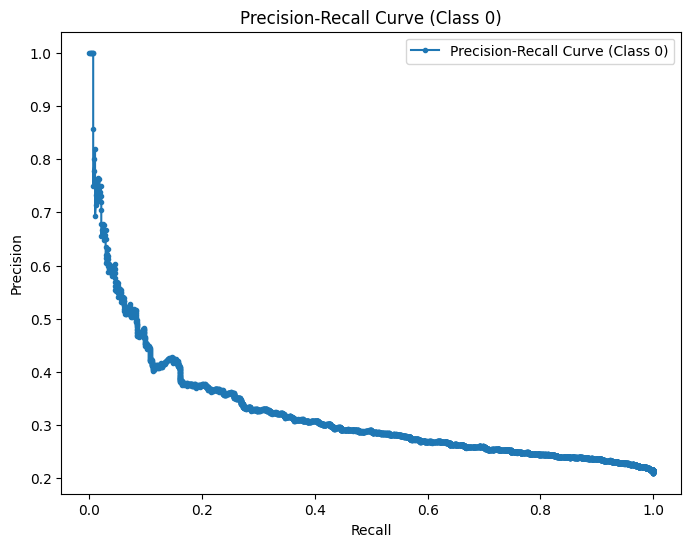

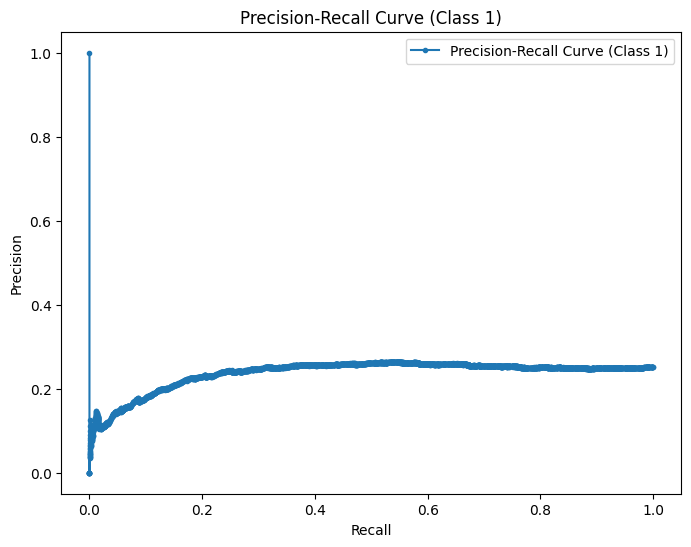

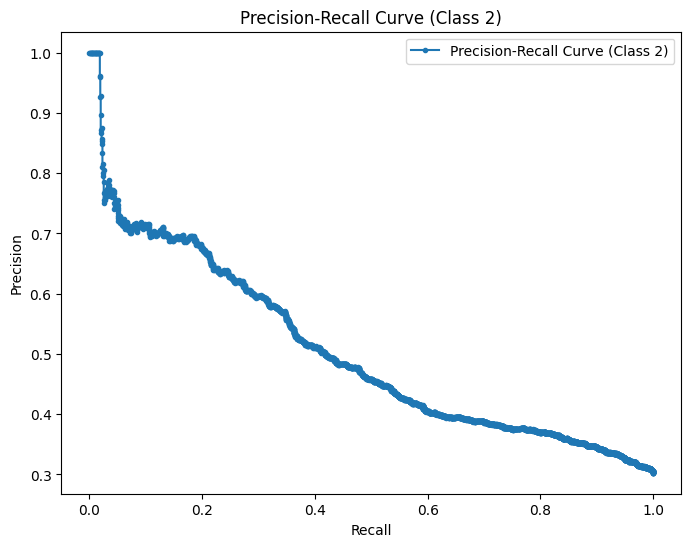

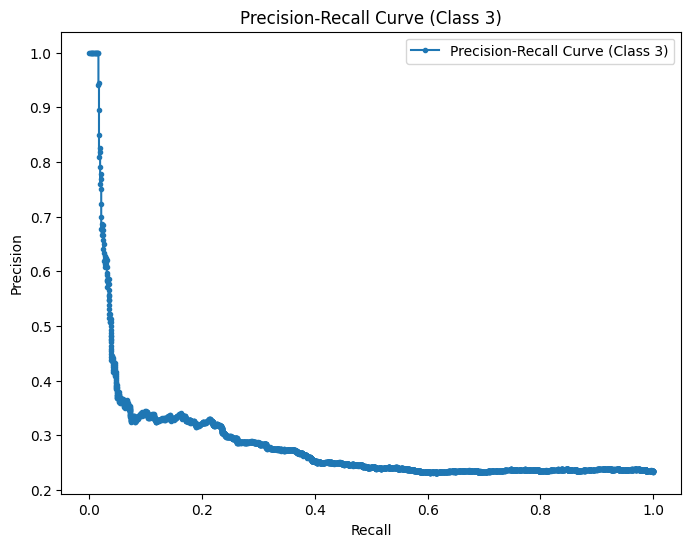

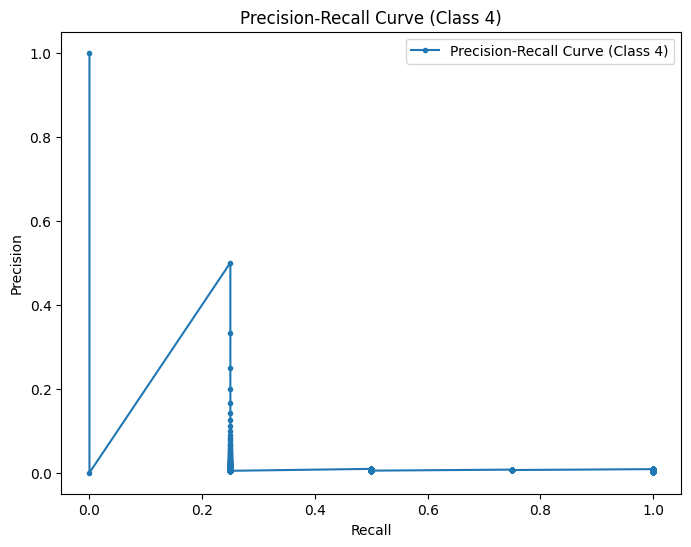

In [5]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetMulticlass'  
weights_path = 'Metriche_NoAug/ResNet18_Metriche_NoAug/ResNet_saved_models_MultiClasse_NoAug_10Patience/resnet18_finetuned.pth'
metrics_path = 'Metriche_NoAug/ResNet18_Metriche_NoAug/ResNet_saved_models_MultiClasse_NoAug_10Patience/training_metrics.csv'
results_path = 'testing/ResNet_Multiclasse_best_NoAug.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Probabilità per ogni classe
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(results, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall'])
        writer.writerow(results)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18()
num_ftrs = model.fc.in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

# Modifica il livello finale del modello
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello tranne l'ultimo livello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    state_dict = torch.load(absolute_weights_path, map_location=torch.device('cpu'))
    state_dict['fc.weight'] = model.fc.weight
    state_dict['fc.bias'] = model.fc.bias
    model.load_state_dict(state_dict, strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test con gestione delle eccezioni
def load_dataset_with_error_handling(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")

    dataset = datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

    valid_samples = []
    for path, target in dataset.samples:
        try:
            dataset.loader(path)  # Try to load the image to ensure it's valid
            valid_samples.append((path, target))
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: {path}")

    dataset.samples = valid_samples
    return dataset

test_dataset = load_dataset_with_error_handling('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Calcola la curva Precision-Recall per ogni classe
for i in range(num_classes):
    precisions, recalls, thresholds = precision_recall_curve([1 if label == i else 0 for label in all_labels], all_probs[:, i])
    
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label=f'Precision-Recall Curve (Class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class {i})')
    plt.legend()
    plt.show()

# Non possiamo impostare una soglia specifica per un problema multiclasse come facciamo per un problema binario,
# ma possiamo calcolare le metriche complessive e salvare i risultati.
test_results = [test_loss, test_acc, test_f1, test_precision, test_recall]
save_test_results(test_results, results_path)


## EfficientNet Binario 


Directory exists: DatasetBinario
Directory exists: DatasetBinario\test
Number of classes: 2
Caricamento dei pesi salvati da C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\EfficientNet_Binario_NoAug\best_model.pth


C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 4.4872 Acc: 0.3682 F1: 0.3654 Precision: 0.8277 Recall: 0.3682


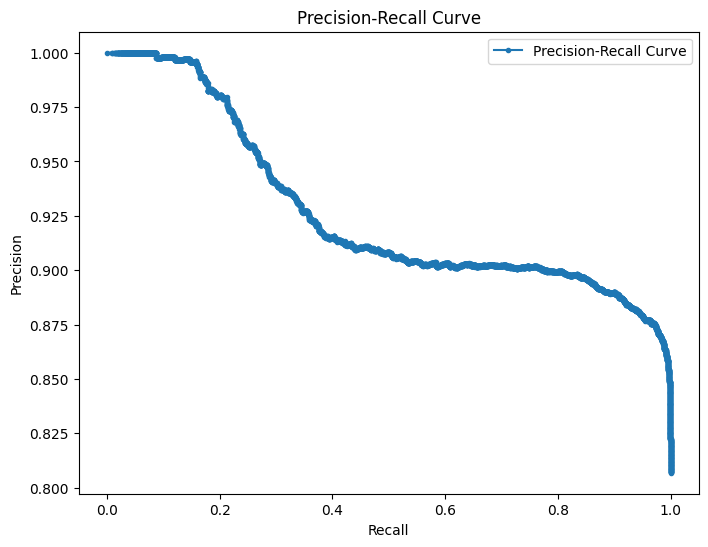

Specific Threshold: 0.5
Precision: 0.8277, Recall: 0.3682, F1: 0.3654


In [11]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetBinario'  
weights_path = 'EfficientNet_Binario_NoAug/best_model.pth'
metrics_path = 'EfficientNet_Binario_NoAug/training_metrics.csv'
results_path = 'testing/EfficientNet_Binary_NoAug.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilità della classe positiva
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(results, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall', 'Threshold', 'Threshold Precision', 'Threshold Recall', 'Threshold F1'])
        writer.writerow(results)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modifica per EfficientNet
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=False)  # In questo esempio, usiamo EfficientNet-B0, puoi cambiare la versione se necessario
num_ftrs = model.classifier[1].in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    model.load_state_dict(torch.load(absolute_weights_path, map_location=device), strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test
test_dataset = load_dataset('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Calcola la curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probs)

# Visualizzazione della curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Imposta una soglia specifica
threshold = 0.5
specific_preds = (all_probs >= threshold).astype(int)
specific_precision = precision_score(all_labels, specific_preds, average='weighted', zero_division=1)
specific_recall = recall_score(all_labels, specific_preds, average='weighted', zero_division=1)
specific_f1 = f1_score(all_labels, specific_preds, average='weighted', zero_division=1)

print(f'Specific Threshold: {threshold}')
print(f'Precision: {specific_precision:.4f}, Recall: {specific_recall:.4f}, F1: {specific_f1:.4f}')

# Salva i risultati del test inclusa la soglia e le metriche relative
test_results = [test_loss, test_acc, test_f1, test_precision, test_recall, threshold, specific_precision, specific_recall, specific_f1]
save_test_results(test_results, results_path)


## EfficientNet Multiclasse

Directory exists: DatasetMulticlass
Directory exists: DatasetMulticlass\test
Number of classes: 5
Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\EfficientNet_Multiclasse_NoAug\best_model.pth


C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ddefs\Documents\University\FVAB - Nappi\Project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 1.6067 Acc: 0.3029 F1: 0.1408 Precision: 0.7889 Recall: 0.3029


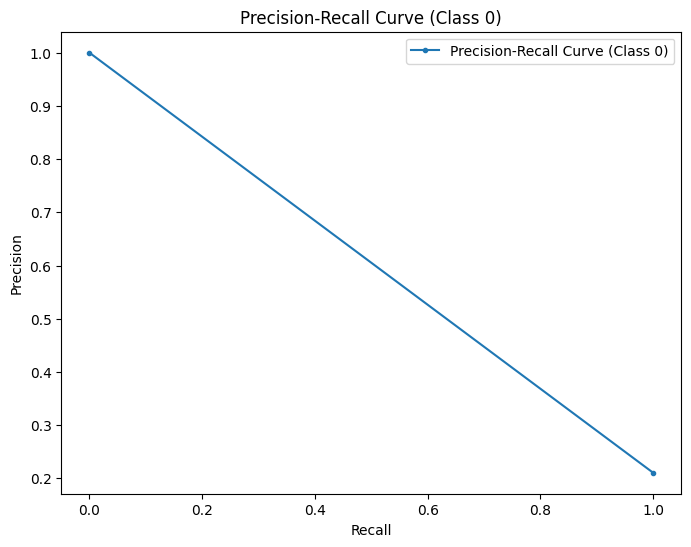

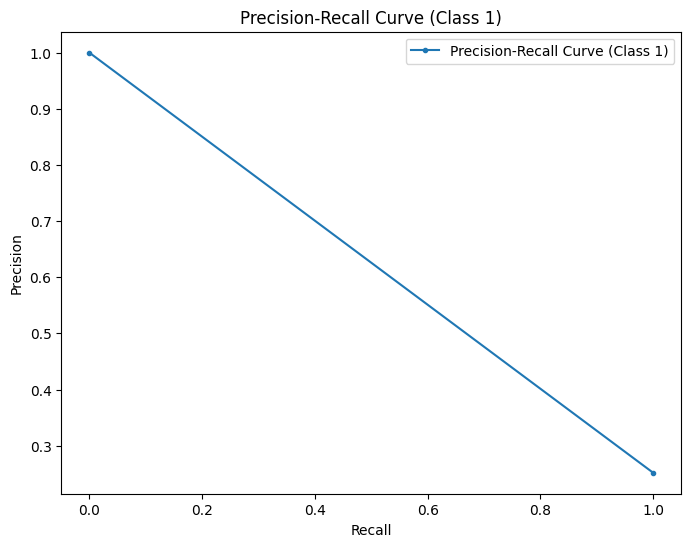

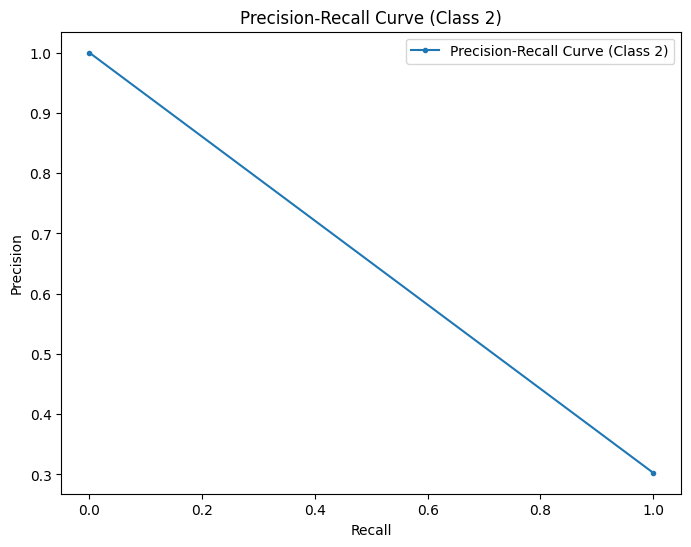

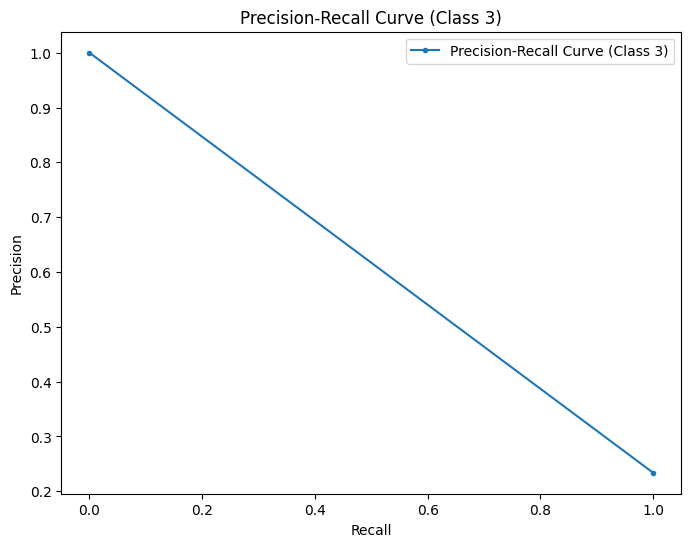

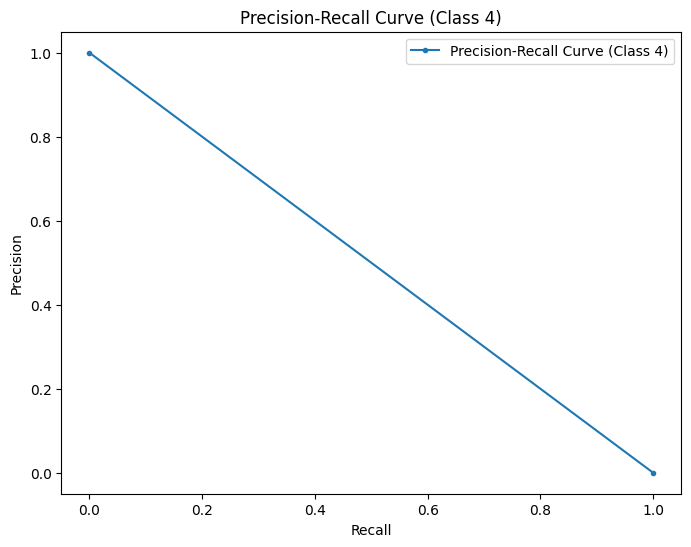

In [13]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import csv
import matplotlib.pyplot as plt
import numpy as np

# Configurazione dei percorsi
dataset_dir = 'DatasetMulticlass'  
weights_path = 'EfficientNet_Multiclasse_NoAug/best_model.pth'
metrics_path = 'EfficientNet_Multiclasse/training_metrics.csv'
results_path = 'testing/EfficientNet_Multiclasse_best_NoAug.csv'

# Verifica se il percorso del dataset è corretto
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Directory not found: {dataset_dir}")
else:
    print(f"Directory exists: {dataset_dir}")

# Trasformazioni
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Funzione di filtro per i file validi
def is_valid_file(file_path):
    valid_extensions = ['.png', '.jpg', '.jpeg']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions) and '.ipynb_checkpoints' not in file_path

# Funzione per caricare il dataset
def load_dataset(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")
    return datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

# Funzione di test
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Probabilità per ogni classe
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')

    return test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs

# Funzione per salvare i risultati del test
def save_test_results(results, results_path):
    with open(results_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Loss', 'Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall'])
        writer.writerow(results)

# Caricamento del modello e impostazioni
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modifica per EfficientNet
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=False)  # In questo esempio, usiamo EfficientNet-B0, puoi cambiare la versione se necessario
num_ftrs = model.classifier[1].in_features

# Determina il numero di classi nel dataset di test
test_dir = os.path.join(dataset_dir, 'test')
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Directory not found: {test_dir}")
else:
    print(f"Directory exists: {test_dir}")

class_folders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
num_classes = len(class_folders)
print(f"Number of classes: {num_classes}")

model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Carica i pesi del modello tranne l'ultimo livello
absolute_weights_path = os.path.abspath(weights_path)
if os.path.exists(absolute_weights_path):
    print(f"Caricamento dei pesi salvati da {absolute_weights_path}")
    state_dict = torch.load(absolute_weights_path, map_location=torch.device('cpu'))
    state_dict['classifier.1.weight'] = model.classifier[1].weight
    state_dict['classifier.1.bias'] = model.classifier[1].bias
    model.load_state_dict(state_dict, strict=False)
else:
    print(f"Nessun peso salvato trovato. Assicurati di avere il file dei pesi salvato in {absolute_weights_path}")

criterion = nn.CrossEntropyLoss()

# Caricamento del dataset di test con gestione delle eccezioni
def load_dataset_with_error_handling(phase):
    dataset_path = os.path.join(dataset_dir, phase)
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directory not found: {dataset_path}")

    dataset = datasets.ImageFolder(dataset_path, transform=data_transforms[phase], is_valid_file=is_valid_file)

    valid_samples = []
    for path, target in dataset.samples:
        try:
            dataset.loader(path)  # Try to load the image to ensure it's valid
            valid_samples.append((path, target))
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: {path}")

    dataset.samples = valid_samples
    return dataset

test_dataset = load_dataset_with_error_handling('test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Aggiorna i dizionari
image_datasets = {'test': test_dataset}
dataloaders = {'test': test_loader}
dataset_sizes = {'test': len(test_dataset)}

# Esegui il test del modello
test_loss, test_acc, test_f1, test_precision, test_recall, all_labels, all_probs = test_model(model, criterion)

# Converti all_probs in un array NumPy
all_probs = np.array(all_probs)

# Calcola la curva Precision-Recall per ogni classe
for i in range(num_classes):
    precisions, recalls, thresholds = precision_recall_curve([1 if label == i else 0 for label in all_labels], all_probs[:, i])
    
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label=f'Precision-Recall Curve (Class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class {i})')
    plt.legend()
    plt.show()

# Non possiamo impostare una soglia specifica per un problema multiclasse come facciamo per un problema binario,
# ma possiamo calcolare le metriche complessive e salvare i risultati.
test_results = [test_loss, test_acc, test_f1, test_precision, test_recall]
save_test_results(test_results, results_path)
